In [1]:
# !pip install networkx
# !pip install matplotlib

In [2]:
# import os
# os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import networkx as nx

#import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


In [5]:
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

In [6]:
# readme = !cat data/students/readme.txt
# print('\n'.join(readme).replace('�',''))

In [7]:
edgesDF = pd.read_csv('data/students/multigraph_hashAnonymized.csv',header=0, names=['source', 'target', 'type'])
print(edgesDF.shape)
edgesDF.head()

(360, 3)


,source,target,type
0,1,81,Partners
1,1,81,Time
2,2,27,Time
3,2,136,Time
4,2,129,Partners


In [8]:
## WARN: Duplicates detected!!!

edgesDF[(edgesDF.source == 13) & (edgesDF.target == 27)]

,source,target,type
44,13,27,Partners
45,13,27,Computer
46,13,27,Time


In [9]:
edgesDF = edgesDF[['source', 'target']].drop_duplicates()

In [10]:
name, freq = np.unique(edgesDF.values.flatten(), return_counts=True)
nodesDF = pd.DataFrame({'name': name, 'freq': freq})
print(nodesDF.shape)
nodesDF.head()

(185, 2)


,name,freq
0,1,1
1,2,4
2,3,3
3,4,3
4,5,4


In [11]:
G = nx.DiGraph()
G.add_edges_from(edgesDF[['source', 'target']].values.tolist())
print('Number of nodes in DiGraph: {}'.format(G.number_of_nodes()))

Number of nodes in DiGraph: 185


In [12]:
## SUBSET OF NODES

longest_list = nx.dag_longest_path(G)
longest_list


[2, 27, 30, 31, 117, 118, 163, 173]

In [13]:
## CHECK ANSWER

nx.shortest_path(G, source=longest_list[0], target=longest_list[-1])

[2, 27, 30, 117, 118, 173]

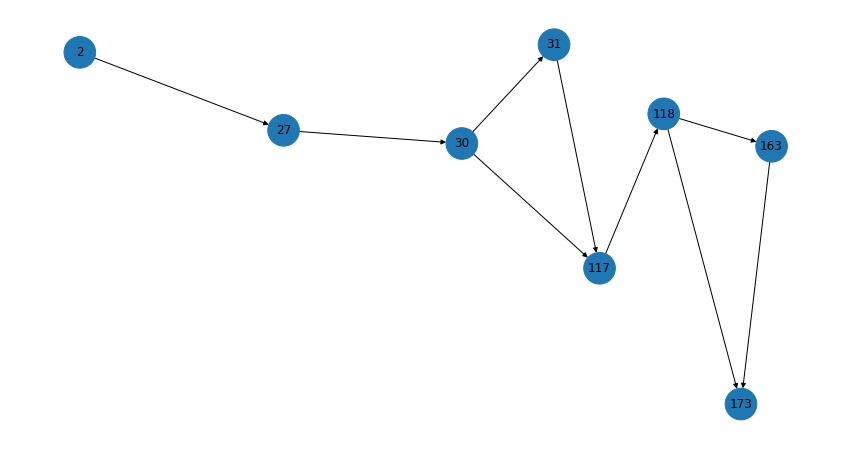

In [32]:
G_filtered = nx.subgraph_view(G, filter_node=lambda x: x in longest_list)

fig, ax = plt.subplots(figsize=(15, 8))
node_sizes = [1000]* len(G_filtered.nodes)
nx.draw_spring(G_filtered, with_labels = True, node_size=node_sizes)

#### PYSPARK PART

In [15]:
edges = spark.createDataFrame(edgesDF)
edges.show(5)

+------+------+
|source|target|
+------+------+
|     1|    81|
|     2|    27|
|     2|   136|
|     2|   129|
|     2|    45|
+------+------+
only showing top 5 rows



In [16]:
# nodes = spark.createDataFrame(nodesDF)
# nodes.show(5)

#### COPYPASTE
https://dwgeek.com/spark-sql-recursive-dataframe-pyspark-and-scala.html/

In [17]:
# initial DataFrame

BEG = 2
END = 173

edges_join = edges \
  .withColumnRenamed('source', 'level_0') \
  .withColumnRenamed('target', 'level_1')

i = 1

levels = ['level_0', 'level_1']

while True:
    this_level = 'level_{}'.format(i)
    next_level = 'level_{}'.format(i+1)
    edges_level = edges \
    .withColumnRenamed('source', this_level) \
    .withColumnRenamed('target', next_level)
    edges_join = edges_join.join(edges_level, on=this_level, how='left')
    
    levels.append(next_level)
    
    # Check if DF is empty. Break loop if empty, Otherwise continue with next level
    if edges_join.where(F.col(next_level).isNotNull()).count() == 0:
        break
    else:
        i += 1

# Sort columns and show
edges_fin = (
    edges_join
    .sort('level_0')
    .select(*levels)
    .filter(F.col('level_0') == F.lit(BEG)) ## source node
    .fillna(-1)
    .withColumn('levels', F.array(*levels[1:]))
    .withColumn('levels', F.array_remove('levels', -1))
    .select('level_0', 'levels')
    .filter(F.array_contains('levels', END)) ## target node
    .withColumn('length', F.size('levels'))
    .filter(F.col('levels')[F.col('length')-F.lit(1)] == F.lit(END)) ## target node
    .orderBy('length')
    ##.limit(1) ## get shortest
)

edges_fin.show(20,100)

+-------+--------------------------------+------+
|level_0|                          levels|length|
+-------+--------------------------------+------+
|      2|         [27, 30, 117, 118, 173]|     5|
|      2|    [27, 30, 117, 143, 163, 173]|     6|
|      2|     [27, 30, 31, 117, 118, 173]|     6|
|      2|    [27, 30, 117, 118, 163, 173]|     6|
|      2|[27, 30, 31, 117, 143, 163, 173]|     7|
|      2|[27, 30, 31, 117, 118, 163, 173]|     7|
+-------+--------------------------------+------+



In [18]:
# edges_fin.printSchema()

#### MAYBE BFS

In [19]:
def find_shortest_path(edges, beg, end):
    """
    """
    BEG = beg
    END = end

    i = 0

    this_level = 'level_{}'.format(i)
    next_level = 'level_{}'.format(i+1)

    edges_join = (
        edges
        .withColumnRenamed('source', this_level)
        .withColumnRenamed('target', next_level)
        .filter(F.col(this_level) == F.lit(BEG))
        .withColumn('is_final', F.when(F.col(next_level) == F.lit(END), 1).otherwise(0))
    )


    levels = ['level_0', 'level_1']

    print(levels)
    edges_join.show(100, 200)

    while True:

        is_final = edges_join.filter('is_final == 1').count() > 0
        is_counted = edges_join.where(F.col(next_level).isNotNull()).count() == 0
        
        if is_final or is_counted:
            break
        else:
            i += 1

        this_level = 'level_{}'.format(i)
        next_level = 'level_{}'.format(i+1)

        levels.append(next_level)

        edges_level = edges \
        .withColumnRenamed('source', this_level) \
        .withColumnRenamed('target', next_level) \
        .join(
            
            edges_join.select(this_level).distinct().withColumnRenamed(this_level, next_level).withColumn('is_visited', F.lit(1)), 
            on=next_level, 
            how='left'

            ) \
        .filter('is_visited is null').select(this_level, next_level)

        edges_join = (
            edges_join
            .join(edges_level, on=this_level, how='left')
            .filter(F.col(next_level).isNotNull())
            .withColumn('is_final', F.when(F.col(next_level) == F.lit(END), 1).otherwise(0))
            .select(*levels, 'is_final')
            )

        print(levels)
        edges_join.show(100, 200)


    if is_final:
        path_len = len(levels)-1
        print('Shortest path length from {} to {}: {}'.format(BEG, END, path_len))
        final_path = edges_join.filter('is_final = 1')
        final_path.show()
        return final_path.toPandas()
    else:
        print('Shortest path from {} to {} doesnt exist'.format(BEG, END))
        return None


In [20]:
BEG = 2
END = 173

shortest_path = find_shortest_path(edges, BEG, END)
shortest_path


['level_0', 'level_1']
+-------+-------+--------+
|level_0|level_1|is_final|
+-------+-------+--------+
|      2|     27|       0|
|      2|    136|       0|
|      2|    129|       0|
|      2|     45|       0|
+-------+-------+--------+

['level_0', 'level_1', 'level_2']
+-------+-------+-------+--------+
|level_0|level_1|level_2|is_final|
+-------+-------+-------+--------+
|      2|     27|     29|       0|
|      2|     27|     51|       0|
|      2|     27|    134|       0|
|      2|     27|    102|       0|
|      2|     27|     30|       0|
|      2|    129|    168|       0|
+-------+-------+-------+--------+

['level_0', 'level_1', 'level_2', 'level_3']
+-------+-------+-------+-------+--------+
|level_0|level_1|level_2|level_3|is_final|
+-------+-------+-------+-------+--------+
|      2|    129|    168|    181|       0|
|      2|     27|    102|    159|       0|
|      2|     27|     30|     31|       0|
|      2|     27|     30|    117|       0|
+-------+-------+-------+----

+-------+-------+-------+-------+-------+--------+
|level_0|level_1|level_2|level_3|level_4|is_final|
+-------+-------+-------+-------+-------+--------+
|      2|     27|     30|     31|    177|       0|
|      2|     27|     30|     31|    134|       0|
|      2|     27|    102|    159|    174|       0|
|      2|     27|    102|    159|    180|       0|
|      2|     27|     30|    117|    143|       0|
|      2|     27|     30|    117|    174|       0|
|      2|     27|     30|    117|    177|       0|
|      2|     27|     30|    117|    134|       0|
|      2|     27|     30|    117|    118|       0|
|      2|     27|     30|    117|    121|       0|
+-------+-------+-------+-------+-------+--------+



['level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5']


+-------+-------+-------+-------+-------+-------+--------+
|level_0|level_1|level_2|level_3|level_4|level_5|is_final|
+-------+-------+-------+-------+-------+-------+--------+
|      2|     27|     30|    117|    143|    163|       0|
|      2|     27|     30|     31|    177|    184|       0|
|      2|     27|     30|    117|    177|    184|       0|
|      2|     27|     30|    117|    118|    163|       0|
|      2|     27|     30|    117|    118|    173|       1|
+-------+-------+-------+-------+-------+-------+--------+



Shortest path length from 2 to 173: 5


+-------+-------+-------+-------+-------+-------+--------+
|level_0|level_1|level_2|level_3|level_4|level_5|is_final|
+-------+-------+-------+-------+-------+-------+--------+
|      2|     27|     30|    117|    118|    173|       1|
+-------+-------+-------+-------+-------+-------+--------+



,level_0,level_1,level_2,level_3,level_4,level_5,is_final
0,2,27,30,117,118,173,1


In [21]:
BEG = 13
END = 177

shortest_path = find_shortest_path(edges, BEG, END)
shortest_path

['level_0', 'level_1']
+-------+-------+--------+
|level_0|level_1|is_final|
+-------+-------+--------+
|     13|     27|       0|
|     13|     29|       0|
|     13|     51|       0|
|     13|    102|       0|
+-------+-------+--------+

['level_0', 'level_1', 'level_2']
+-------+-------+-------+--------+
|level_0|level_1|level_2|is_final|
+-------+-------+-------+--------+
|     13|     27|    134|       0|
|     13|     27|     30|       0|
|     13|    102|    159|       0|
+-------+-------+-------+--------+

['level_0', 'level_1', 'level_2', 'level_3']
+-------+-------+-------+-------+--------+
|level_0|level_1|level_2|level_3|is_final|
+-------+-------+-------+-------+--------+
|     13|     27|     30|     31|       0|
|     13|     27|     30|    117|       0|
|     13|    102|    159|    174|       0|
|     13|    102|    159|    180|       0|
+-------+-------+-------+-------+--------+



['level_0', 'level_1', 'level_2', 'level_3', 'level_4']


+-------+-------+-------+-------+-------+--------+
|level_0|level_1|level_2|level_3|level_4|is_final|
+-------+-------+-------+-------+-------+--------+
|     13|     27|     30|     31|    177|       1|
|     13|     27|     30|     31|    134|       0|
|     13|     27|     30|    117|    143|       0|
|     13|     27|     30|    117|    177|       1|
|     13|     27|     30|    117|    134|       0|
|     13|     27|     30|    117|    118|       0|
|     13|     27|     30|    117|    121|       0|
+-------+-------+-------+-------+-------+--------+

Shortest path length from 13 to 177: 4


+-------+-------+-------+-------+-------+--------+
|level_0|level_1|level_2|level_3|level_4|is_final|
+-------+-------+-------+-------+-------+--------+
|     13|     27|     30|     31|    177|       1|
|     13|     27|     30|    117|    177|       1|
+-------+-------+-------+-------+-------+--------+



,level_0,level_1,level_2,level_3,level_4,is_final
0,13,27,30,31,177,1
1,13,27,30,117,177,1


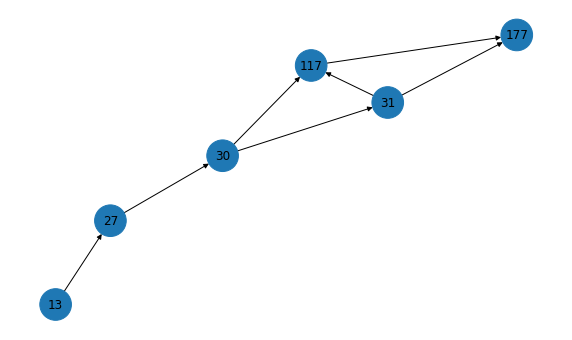

In [29]:
nodes_from_shortest = list(set(shortest_path.iloc[:,:-1].values.flatten()))

G_filtered = nx.subgraph_view(G, filter_node=lambda x: x in nodes_from_shortest)

fig, ax = plt.subplots(figsize=(10, 6))
node_sizes = [1000]* len(G_filtered.nodes)
nx.draw_spring(G_filtered, with_labels = True, node_size=node_sizes)


#### https://hashsum.ru/bfs-algoritm-obxoda-grafa-v-shirinu/

A B C D E F 

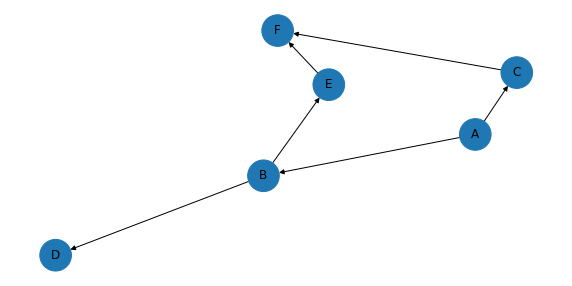

In [23]:
""" ****** Стандартный алгоритм обхода графа в ширину (bfs). ****
 Алгоритм работает следующим образом:
1. Начните с размещения любой вершины графа в конце очереди.
2. Возьмите передний элемент очереди и добавьте его в список посещенных.
3. Создайте список смежных узлов этой вершины. 
 Добавьте те, которых нет в списке посещенных, в конец очереди.
4. Продолжайте повторять шаги 2 и 3, пока очередь не опустеет. 
"""
graph = {
  'A' : ['B','C'],
  'B' : ['D', 'E'],
  'C' : ['F'],
  'D' : [],
  'E' : ['F'],
  'F' : []
}

Graph = nx.DiGraph()
Graph.add_edges_from([(k,i) for k,v in graph.items() for i in v])

fig, ax = plt.subplots(figsize=(10, 5))
node_sizes = [1000]* len(Graph.nodes)
nx.draw_spring(Graph, with_labels = True, node_size=node_sizes)


visited = [] # List to keep track of visited nodes.
queue = []   # Initialize a queue
def bfs(visited, graph, node):
    global queue
    visited.append(node)
    queue.append(node)
    while queue:
        s = queue.pop(0)
        print (s, end = " ")
        for neighbour in graph[s]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)
# Driver Code
bfs(visited, graph, 'A')